In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from PIL import Image

import torch
import torch.nn as nn
import cv2

---

## Data load

In [2]:
pd.read_csv('mpii_human_pose.csv')

,ID,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,1,015601864.jpg,620,394,616,269,573,185,647,188,...,167,692,185,693,240,688,313,3.021046,curling,sports
1,2,015599452.jpg,-1,-1,-1,-1,806,543,720,593,...,281,719,299,711,516,545,466,5.641276,curling,sports
2,3,005808361.jpg,804,711,816,510,908,438,1040,454,...,253,1067,253,1167,353,1142,478,4.718488,curling,sports
3,4,086617615.jpg,301,461,305,375,201,340,294,342,...,261,314,264,327,320,362,346,2.681349,curling,sports
4,5,060111501.jpg,980,322,896,318,865,248,943,226,...,147,923,123,995,163,961,223,3.806403,curling,sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17367,17368,033474347.jpg,876,461,815,380,779,296,742,303,...,214,663,223,674,286,631,260,2.003677,pushing car,transportation
17368,17369,082650067.jpg,1038,656,950,504,903,328,831,337,...,204,729,220,704,332,675,269,3.235820,pushing car,transportation
17369,17370,072772110.jpg,562,617,558,539,553,452,511,458,...,377,490,378,470,411,461,414,1.494952,pushing car,transportation
17370,17371,039361034.jpg,496,377,466,322,510,278,540,280,...,253,466,251,436,293,410,325,1.459468,pushing car,transportation


In [3]:
from collections import defaultdict


def parse_activities(string: str) -> list[str]:
    while string.find(r"(") >= 0:
        first_br = string.find(r"(")
        if (first_br > 0):
            second_br = string.find(r")")
            if second_br > 0:
                string = string[:first_br] + string[second_br+2:]
            else:
                string = string[:first_br]

    return [sub.strip() for sub in string.split(',')]


def get_activities(df: pd.DataFrame):
    categories = set(df['Category'].unique())

    activities = set()
    for _, row in df.iterrows():
        row_activities = parse_activities(row['Activity'])
        activities.update(row_activities)

    categories = list(categories)
    activities = list(activities)

    cat2act = {i: set() for i in range(len(categories))}
    for _, row in df.iterrows():
        row_activities = parse_activities(row['Activity'])
        row_category = row['Category']
        cat2act[categories.index(row_category)].update([activities.index(i) for i in row_activities])

    return np.array(categories), \
           np.array(activities), \
           {i: sorted(np.array(list(st))) for i, st in cat2act.items()}

In [4]:
cat, act, cat2act = get_activities(pd.read_csv('./mpii_human_pose.csv'))

intersections = defaultdict(set)
for cat_idx1, act_idxs1 in cat2act.items():
    for cat_idx2, act_idxs2 in cat2act.items():
        if cat_idx1 != cat_idx2:
            inter = set(act_idxs1) & set(act_idxs2)
            if len(inter) > 0:
                for a in inter:
                    if len(intersections) == 0:
                        intersections[a] = set([cat_idx1, cat_idx2])
                    elif set([cat_idx1, cat_idx2]) not in intersections.values():
                        intersections[a].update(set([cat_idx1, cat_idx2]))

print("Пересекающиеся активности:")
for a, c in intersections.items():
    cats = ', '.join([f"'{cat[i]}'" for i in c])
    print(f"   \'{act[a]}\' -> {cats}")

Пересекающиеся активности:
   'sitting' -> 'miscellaneous', 'self care', 'occupation', 'fishing and hunting', 'religious activities', 'volunteer activities', 'music playing'
   'general' -> 'miscellaneous', 'dancing', 'occupation', 'fishing and hunting', 'bicycling', 'home activities', 'music playing', 'winter activities', 'conditioning exercise', 'water activities', 'sports', 'lawn and garden', 'walking', 'home repair'
   'light effort' -> 'miscellaneous', 'lawn and garden', 'occupation', 'home activities'
   'standing' -> 'miscellaneous', 'occupation', 'fishing and hunting', 'religious activities', 'volunteer activities', 'home activities', 'music playing', 'water activities'
   'painting' -> 'miscellaneous', 'home repair', 'occupation'
   'typing' -> 'miscellaneous', 'occupation'
   'fishing' -> 'occupation', 'fishing and hunting'
   'doing work' -> 'volunteer activities', 'occupation'
   'cleaning' -> 'home activities', 'occupation'
   'walking' -> 'lawn and garden', 'walking', 'oc

In [5]:
from torch.utils.data import Dataset


keypoints_cols = ['r ankle_X', 'r ankle_Y', 'r knee_X', 'r knee_Y', 'r hip_X', 'r hip_Y', 'l hip_X', 'l hip_Y', 
                  'l knee_X', 'l knee_Y', 'l ankle_X', 'l ankle_Y', 'pelvis_X', 'pelvis_Y', 'thorax_X', 'thorax_Y', 
                  'upper neck_X', 'upper neck_Y', 'head top_X', 'head top_Y', 'r wrist_X', 'r wrist_Y', 'r elbow_X', 'r elbow_Y', 
                  'r shoulder_X', 'r shoulder_Y', 'l shoulder_X', 'l shoulder_Y', 'l elbow_X', 'l elbow_Y', 'l wrist_X', 'l wrist_Y']

class BodyKeypointsDataset(Dataset):
    def __init__(self, csv_path, root_dir, transform=None):
        self.dataframe = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform

        self.catecories, self.activities, self.cat2actIds = get_activities(self.dataframe)
        self.output_size = len(self.activities)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.loc[idx, 'NAME'])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        landmarks = self.dataframe.loc[idx, keypoints_cols]
        landmarks = np.array([landmarks], dtype=np.float32).reshape(-1, 2)

        row_activities = parse_activities(self.dataframe.loc[idx, 'Activity'])
        activities = np.array([1.0 if act in row_activities else 0.0 for act in self.activities], dtype=np.float32)

        sample = {'image': image, 'landmarks': landmarks, 'target': activities}

        if self.transform:
            sample = self.transform(sample)

        return sample

1) Image size: (720, 1280, 3), Landmarks: (16, 2)
2) Image size: (1080, 1920, 3), Landmarks: (16, 2)
3) Image size: (720, 1280, 3), Landmarks: (16, 2)
4) Image size: (1080, 1920, 3), Landmarks: (16, 2)
5) Image size: (1080, 1920, 3), Landmarks: (16, 2)
6) Image size: (720, 1280, 3), Landmarks: (16, 2)
7) Image size: (1080, 1440, 3), Landmarks: (16, 2)
8) Image size: (720, 1280, 3), Landmarks: (16, 2)
9) Image size: (720, 1280, 3), Landmarks: (16, 2)


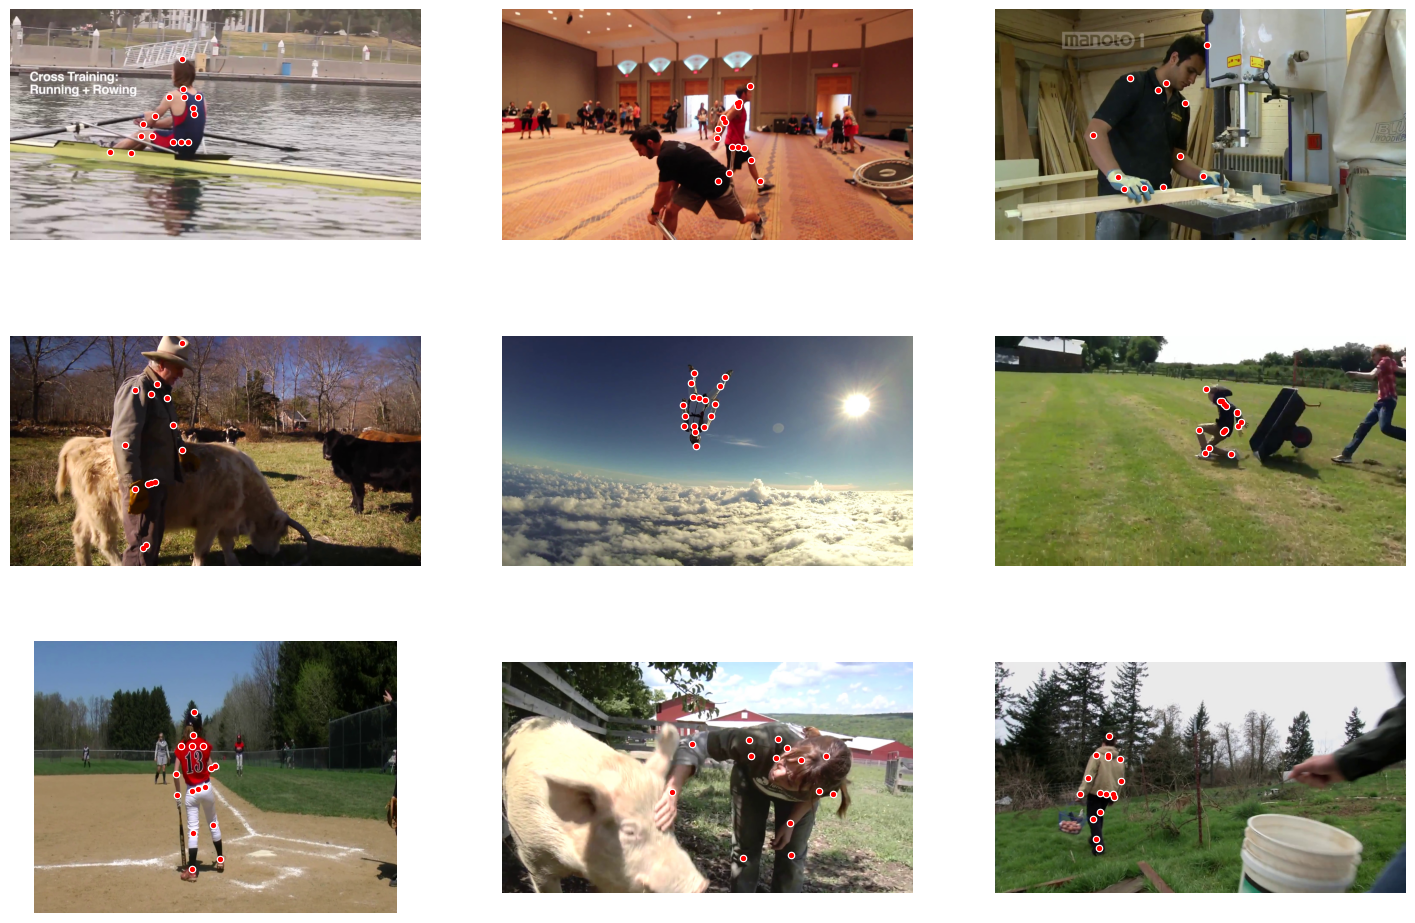

In [6]:
dataset = BodyKeypointsDataset(csv_path='./var_13.csv', root_dir='./test_dataset/')


def show_landmarks(image, landmarks, r=30):
    plt.imshow(image)
    xs = [x for x in landmarks[:, 0] if x >= 0]
    ys = [y for y in landmarks[:, 1] if y >= 0]
    plt.scatter(xs, ys, s=r+50, marker='.', c='w')
    plt.scatter(xs, ys, s=r, marker='.', c='r')


plt.figure(figsize=(18, 12), frameon=False)
for i, sample_idx in enumerate(np.random.choice(len(dataset), size=9)):
    sample = dataset[sample_idx]
    print(f"{i+1}) Image size: {sample['image'].shape}, Landmarks: {sample['landmarks'].shape}")

    plt.subplot(3, 3, i + 1)
    show_landmarks(sample['image'], sample['landmarks'])
    plt.axis('off')

---

## Transform

In [7]:
from skimage import transform

In [8]:
from torchvision import transforms

class Rescale:
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if h > w:
            new_h, new_w = self.output_size * h / w, self.output_size
        else:
            new_h, new_w = self.output_size, self.output_size * w / h

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks, 'target': sample['target']}

class RandomCrop:
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size


    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size, self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]
        landmarks = np.array([key if key[0] >= 0 and key[0] <= new_w and key[1] >= 0 and key[1] <= new_h else [-1, -1] for key in landmarks])

        return {'image': image, 'landmarks': landmarks, 'target': sample['target']}

class SquareCropAndResize:
    def __init__(self, output_size: int):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size, self.output_size

        over_w = new_w - w
        over_h = new_h - h
        if over_w > 0 or over_h > 0:
            if over_w > over_h:
                image = transform.resize(image, (int(self.output_size * h / w), new_w))
            else:
                image = transform.resize(image, (new_h, int(self.output_size * w / h)))
            landmarks = landmarks * [image.shape[1] / w, image.shape[0] / h]
            h, w = image.shape[:2]

        xs = [x for x in landmarks[:, 0] if x >= 0]
        ys = [y for y in landmarks[:, 1] if y >= 0]
        cx, cy = int(sum(xs) / len(xs)), int(sum(ys) / len(ys))

        top = int(cy - new_h / 2)
        left = int(cx - new_w / 2)
        bottom = int(cy + new_h / 2)
        right = int(cx + new_w / 2)

        y_offset = 0
        if top < 0: y_offset = -top
        elif bottom > h: y_offset = h - bottom
        
        x_offset = 0
        if left < 0: x_offset = -left
        elif right > w: x_offset = w - right

        left = int(left + x_offset)
        right = int(right + x_offset)
        top = int(top + y_offset)
        bottom = int(bottom + y_offset)
        # print(top, bottom, left, right, "Shape: ", image.shape[:2], "CoM: ", (int(cy), int(cx)), "Offset: ", (y_offset, x_offset))

        image = image[top: bottom, left: right]

        landmarks = landmarks - [left, top]
        landmarks = np.array([key if key[0] >= 0 and key[0] <= new_w and key[1] >= 0 and key[1] <= new_h else [-1, -1] for key in landmarks])

        return {'image': image, 'landmarks': landmarks, 'target': sample['target']}
    


class ToTensor:
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image.astype(np.float32)), 
                'landmarks': torch.from_numpy(landmarks.astype(np.float32)), 
                'target': torch.from_numpy(sample['target'].astype(np.float32))}
    
class Normalize:
    def __init__(self, output_size: int):
        assert isinstance(output_size, int)
        self.output_size = output_size

        # self.image_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                                             std=[0.229, 0.224, 0.225])

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': image / 255.0, 
                'landmarks': landmarks / self.output_size, 
                'target': sample['target']}

In [9]:
composed = transforms.Compose([SquareCropAndResize(1024), 
                               RandomCrop(640), 
                               Rescale(224)])

dataset = BodyKeypointsDataset(csv_path='./var_13.csv', root_dir='./test_dataset/', transform=composed)

1) Image size: (224, 224, 3), Landmarks: (16, 2)
2) Image size: (224, 224, 3), Landmarks: (16, 2)
3) Image size: (224, 224, 3), Landmarks: (16, 2)
4) Image size: (224, 224, 3), Landmarks: (16, 2)
5) Image size: (224, 224, 3), Landmarks: (16, 2)
6) Image size: (224, 224, 3), Landmarks: (16, 2)
7) Image size: (224, 224, 3), Landmarks: (16, 2)
8) Image size: (224, 224, 3), Landmarks: (16, 2)
9) Image size: (224, 224, 3), Landmarks: (16, 2)


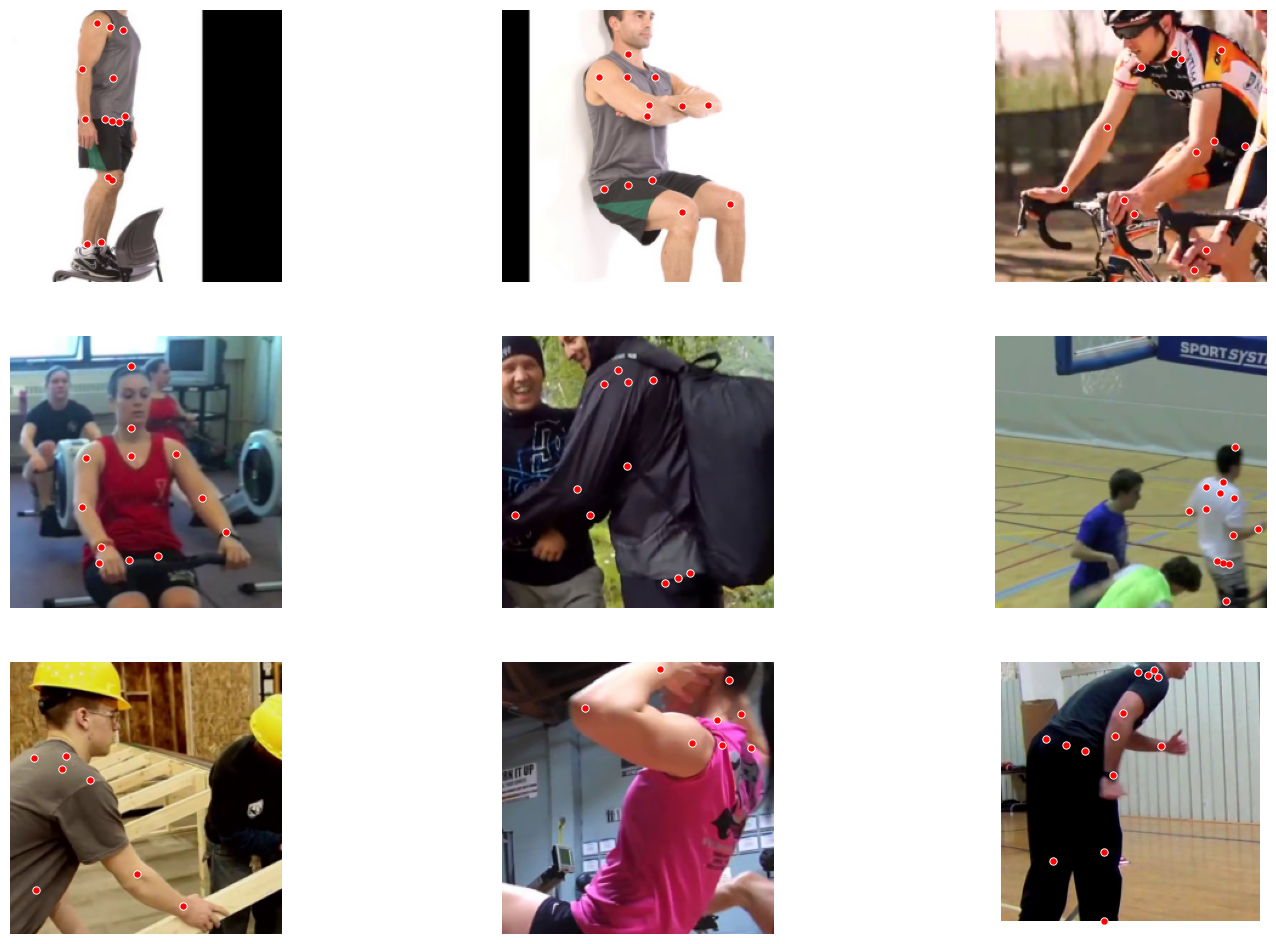

In [10]:
plt.figure(figsize=(18, 12), frameon=False)
for i, sample_idx in enumerate(np.random.choice(len(dataset), size=9)):
    sample = dataset[sample_idx]
    print(f"{i+1}) Image size: {sample['image'].shape}, Landmarks: {sample['landmarks'].shape}")

    plt.subplot(3, 3, i + 1)
    show_landmarks(sample['image'], sample['landmarks'], r=50)
    plt.axis('off')

---

## Prepare final dataset

In [11]:
composer = transforms.Compose([SquareCropAndResize(224), 
                            #    RandomCrop(640), 
                              #  Rescale(224),
                               Normalize(224),
                               ToTensor()])

final_dataset = BodyKeypointsDataset(csv_path='./var_13.csv', root_dir='./test_dataset/', transform=composer)

print(len(final_dataset))

789


In [12]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader


train_set, val_set = random_split(final_dataset, [648, 141]) #[14000, 3372]

batch_size = 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')  


def to_device(data, device):
    if isinstance(data, dict):
        return {k: to_device(v, device) for k, v in data.items()}
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

---

## Model design

In [15]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [16]:
import torch.nn.functional as F


class ModelBase(nn.Module):
    def training_step(self, batch):
        images = batch['image']
        landmarks = batch['landmarks']
        targets = batch['target']

        out = self(images, landmarks)
        loss = F.binary_cross_entropy(out, targets)
        return loss    

    def validation_step(self, batch):
        images = batch['image']
        landmarks = batch['landmarks']
        targets = batch['target']

        out = self(images, landmarks) 
        loss = F.binary_cross_entropy(out, targets)
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach()}      


    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}    

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [17]:
import timm

features_input_size = len(keypoints_cols)
num_classes = len(final_dataset.activities)


class Model(ModelBase):
    def __init__(self):
        super(Model, self).__init__()
        self.vit = timm.create_model('google/vit_base_patch16_224', pretrained=True)
        self.vit.requires_grad_(False)
        self.vit.head = nn.Linear(self.vit.head.in_features, 512)
        self.vit.head.requires_grad_(True)

        self.input_layer = nn.Linear(features_input_size, 512)
        self.headen_layer = nn.Linear(1024, 256)
        self.output_layer = nn.Linear(256, num_classes)
        
    def forward(self, image, features):
        x1 = F.relu(self.vit(image))

        x2 = features.view(batch_size, -1)
        x2 = F.relu(self.input_layer(x2))

        x = torch.cat((x1, x2), 1)

        x = F.relu(self.headen_layer(x))

        x = self.output_layer(x)
        x = F.sigmoid(x)
        
        return x

In [18]:
num_classes

87

In [19]:
model = Model()
model = to_device(model, device)
model

Model(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
        

---

## Train

In [20]:
optimizer = torch.optim.AdamW(model.parameters() , lr = 0.001)

In [21]:
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    for batch in val_loader:
        if len(batch["image"]) == batch_size:
            outputs.append(model.validation_step(batch))
    return model.validation_epoch_end(outputs)


def fit(epochs, model, train_loader, val_loader):
    history = []
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.AdamW):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 2.4021830558776855, 'val_score': 0.03672081604599953}]

In [23]:
%%time

history += fit_one_cycle(epochs=20, 
                         max_lr=0.001, 
                         model = model, 
                         train_loader=train_dl,
                         val_loader=val_dl,
                         grad_clip=0.1, 
                         weight_decay=1e-4)

  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [0], last_lr: 0.0001, train_loss: 0.5669, val_loss: 0.1482, val_score: 0.0176


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [1], last_lr: 0.0003, train_loss: 0.1196, val_loss: 0.1152, val_score: 0.0343


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [2], last_lr: 0.0005, train_loss: 0.0958, val_loss: 0.1162, val_score: 0.0233


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [3], last_lr: 0.0008, train_loss: 0.0872, val_loss: 0.1328, val_score: 0.0922


  0%|          | 0/81 [00:00<?, ?it/s]

Epoch [4], last_lr: 0.0009, train_loss: 0.0820, val_loss: 0.1177, val_score: 0.0699


  0%|          | 0/81 [00:00<?, ?it/s]

KeyboardInterrupt: 

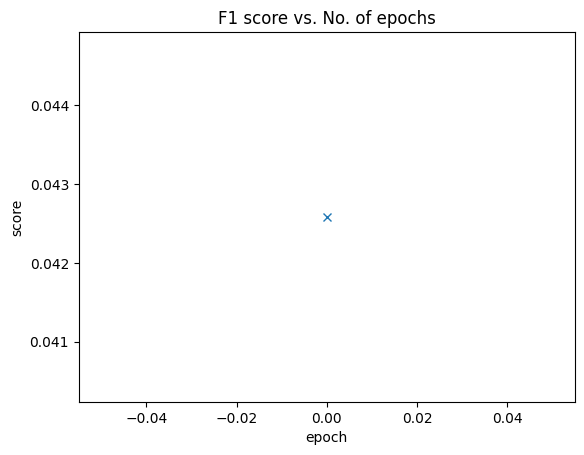

In [199]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

In [16]:
from sklearn.metrics import confusion_matrix
import itertools


def plot_confusion_matrix(y_valid, y_pred,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_valid, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()